# Tutorial on Recognizing Noise in EEG

This notebook provides an interactive introduction to common forms of noise in iEEG signals. We cover 
* pink (1/f) background spectra
* white noise
* line noise


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import mne

from eegsim import EEGGen

In [172]:
# Generate EEG.
def generate_eeg_events(gen,
                        n_events=1,
                        duration=1  # seconds
                       ):
    eeg = list()
    for ev in range(n_events):
        eeg.append(gen.Generate(duration).reshape(1, 1, -1))
    return np.concatenate(eeg, axis=0)

# Plot the time-domain traces.
def plot_time(time, eeg):
    n_cols = 3
    n_rows = n_events // n_cols + ((n_events % n_cols) == 1)
    fig = plt.figure(figsize=(40, 10))
    plt.subplot(n_rows, n_cols, 1)
    plt.suptitle('EEG Traces over Time', fontsize=35)
    for ev in range(n_events):
        plt.subplot(n_rows, n_cols, ev + 1)
        plt.plot(time, eeg[ev, 0])
        if np.ceil(ev / n_cols) == np.ceil(n_rows / 2) - 1 and (ev % n_cols == 0):
            plt.ylabel('Voltage (uV)', fontsize=25)
        if np.ceil(ev % n_cols) == (np.ceil(n_cols / 2) - 1) and (np.ceil(ev / n_cols) == n_rows):
            plt.xlabel('Time (s)', fontsize=25)

# Plot the PSD averaged across traces
def plot_psd(eeg):
    fig = plt.figure()
    ax = plt.subplot(1, 1, 1)
    fig.suptitle('Power Spectral Density', fontsize=15)
    fig = eeg.plot_psd(fmin=3, fmax=200, 
                       picks='all', 
                       xscale='log', ax=[ax])
    return fig


def plot_eeg_signal(gen, 
                    duration=1  # seconds
                   ):
    eeg = generate_eeg_events(gen, n_events=9, duration=duration)

    time = gen.time_coords - duration / 2.0
    plot_time(time, eeg)

    chans = ['CH1']
    info = mne.create_info(ch_names=chans, 
                           ch_types=['misc'] * len(chans), 
                           sfreq=sample_rate)
    eeg_mne = mne.EpochsArray(data=eeg, info=info)
    # eeg_mne.plot(picks='all', n_epochs=3)
    _ = plot_psd(eeg_mne)

## Common EEG Components and Noise Signals

Pink noise forms the 1/f background spectra of the brain.
This background spectra will be present in clean EEG and will show up in the power spectra as a decreasing linear function of frequency on a log-log plot.
Pink noise signals are auto-correlated, i.e. they are correlated with themselves at nearby time points.

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/3079950.1.jupyter.q/ipykernel_69998/1277584110.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  xscale='log', ax=[ax])


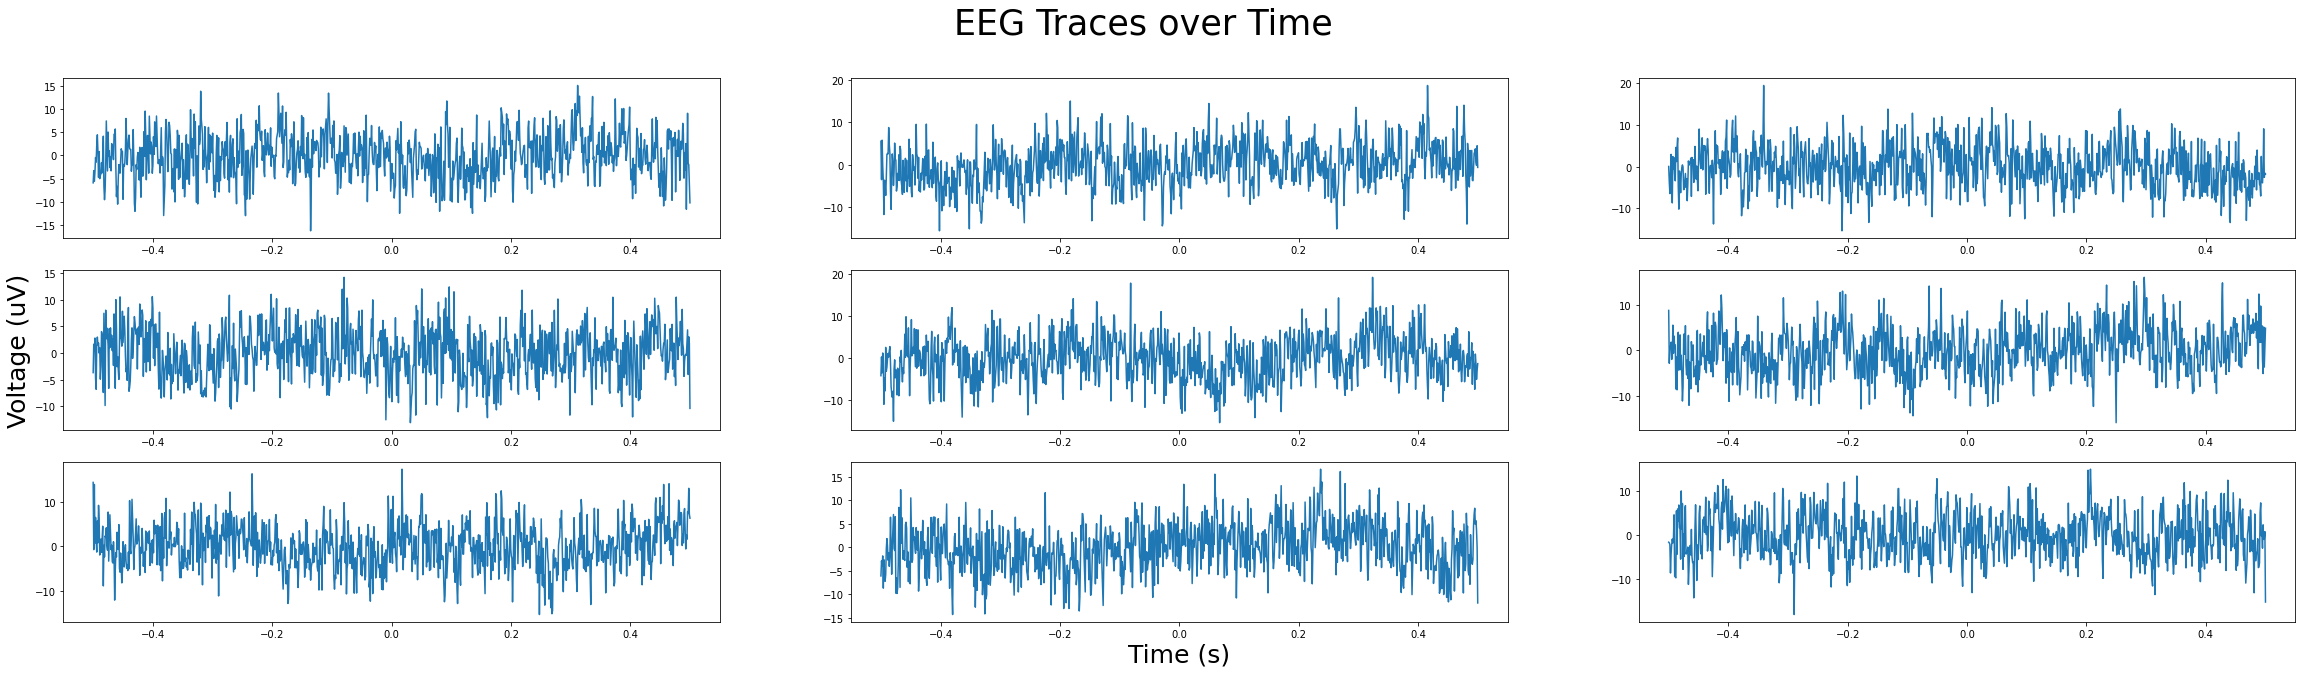

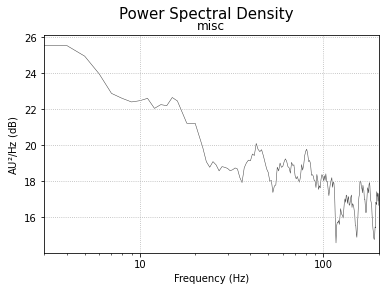

In [180]:
# generate pink noise

eeg_scale = 10  # uV
sample_rate = 1000  # Hz

# EEG generator instance
gen = EEGGen(sampling_rate=sample_rate)

# Set the pink noise amplitude.
pink_scale = 0.5
pink_exponent = 0.51  #0.51
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

plot_eeg_signal(gen)

The pink noise spectrum will often be accompanied by a (weak) theta oscillation, which will show up as a bump in the theta band (4 - 8 Hz) on top of the pink noise background spectrum.

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/3079950.1.jupyter.q/ipykernel_69998/1277584110.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  xscale='log', ax=[ax])


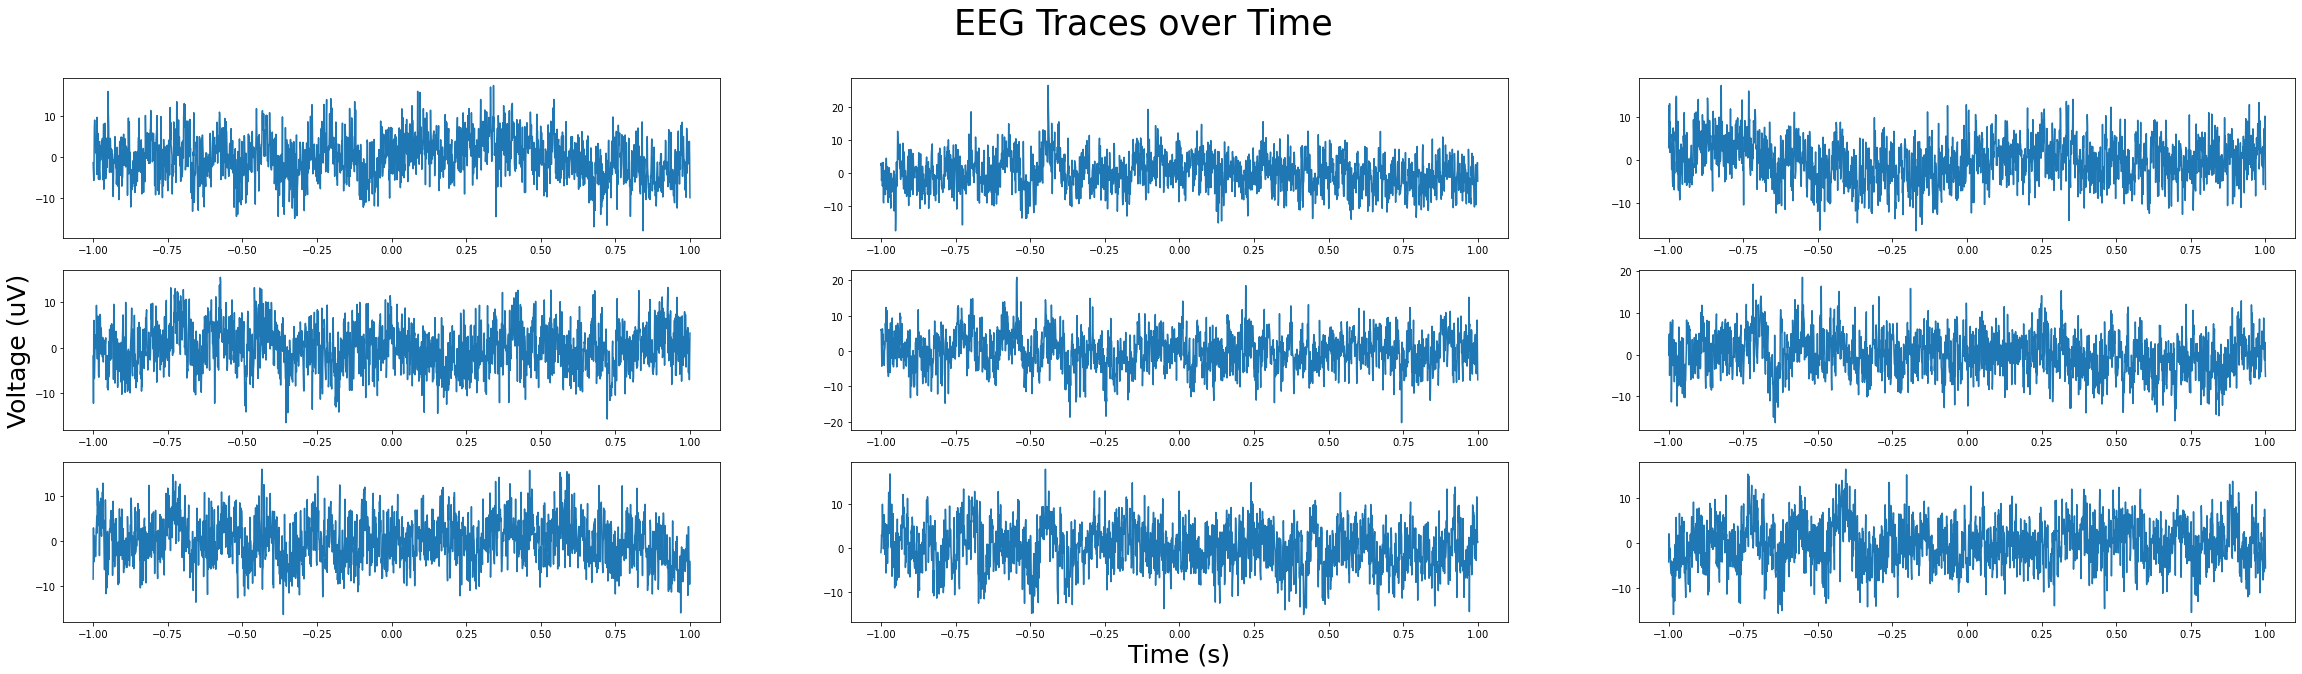

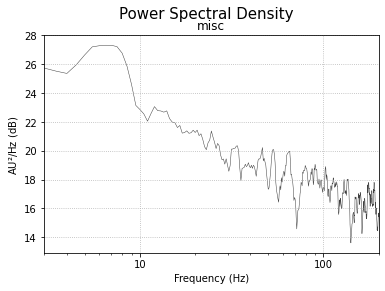

In [178]:
# pink noise with theta oscillation

gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

# add (sinusoidal) oscillatory bout
# Note:  Generator time starts from 0.
osc_freq = 7  # Hz
osc_amplitude_scale = 0.35
osc_offset = 0.25
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=3)

plot_eeg_signal(gen, duration=2)

White noise signals have even spectral power, i.e. they are uncorrelated in time. 
These signals undulate (slowly rise and fall) far less than pink noise signals, indicative of no dependence on nearby times (as is the case for pink noise).
White noise can indicate electrical noise, potentially from a poor connection. 
For EEG troubleshooting, white noise signals due to poorly connected or disconnected cables will often be seen with a different signal scale or variability. In other words, the range of signal values will fall out of the 1-10 uV range typical for clean EEG.

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/3079950.1.jupyter.q/ipykernel_69998/1277584110.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  xscale='log', ax=[ax])


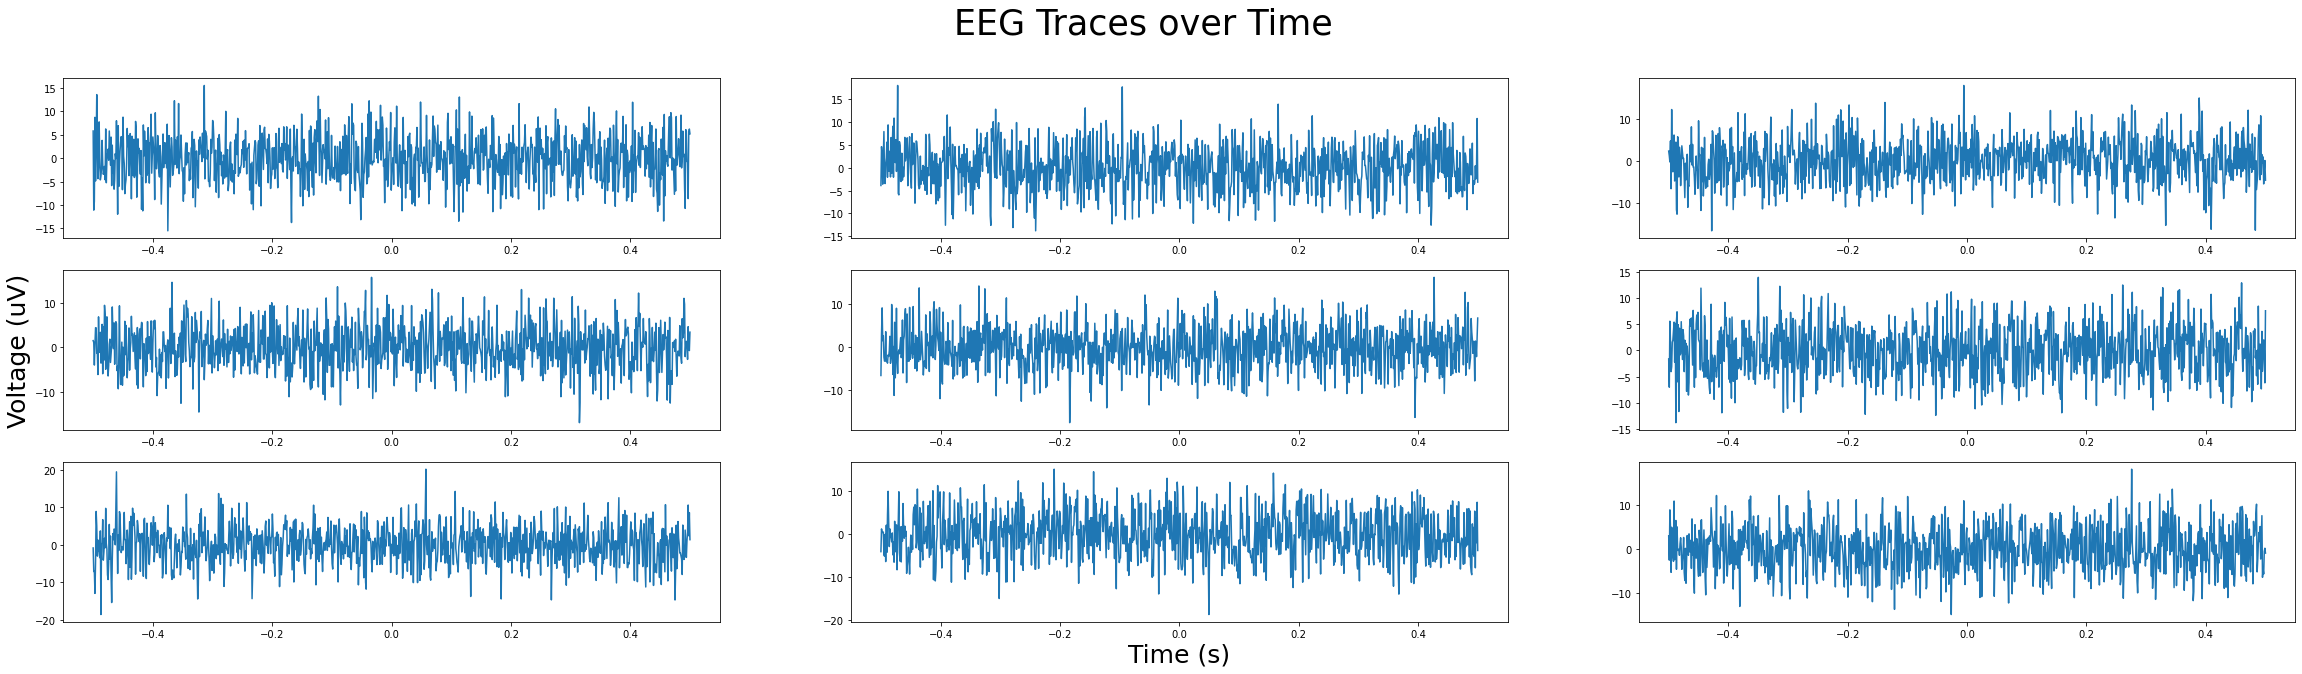

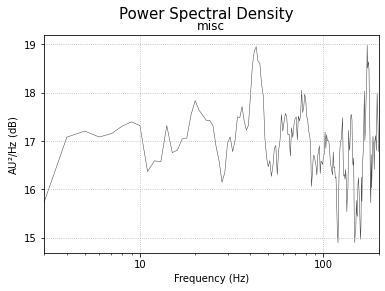

In [179]:
# generate white noise
gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.0
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

plot_eeg_signal(gen)

Most obviously and critically, line noise will show up as strong oscillatory components unrelated to bands of interest (such as the theta band). In particular, line noise will frequently be seen at 
* 60 Hz, the frequency of the US power grid
* At integer multiples (the higher harmonics) of 60 Hz: 120 Hz and 180 Hz
* At integer divisions (the subharmonics) of 60 Hz along with harmonics of the subharmonics: typically 20 Hz and integer multiples of 20 Hz

Line noise can be spotted 
* in the time domain as periodic peaks (which will rise and fall due to the other components in the signal)
    * Given the consistency of the power grid (the primary source of line noise), line noise will typically (but not always) be far more consistent than other signal components
* in the PSD as bumps near the suspicious frequencies.

Line noise is one key form of noise that we need to check for and optimize before making recordings. Some line noise will always be present, but line noise greater than 3 decibels (dB) above the background spectra is cause for concern and can indicate 
* A powerful electrical device is on in the recording room
    * Some other devices are obviously necessary in a clinical setting, but try to remove any that are not needed and pay attention to unusual devices that were not present in previous sessions.
* A faulty grounding connection is in place, which will severely amplify even acceptable amounts of noise
* The universal power supply (UPS) is connected to a wall outlet

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/3079950.1.jupyter.q/ipykernel_69998/1277584110.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  xscale='log', ax=[ax])


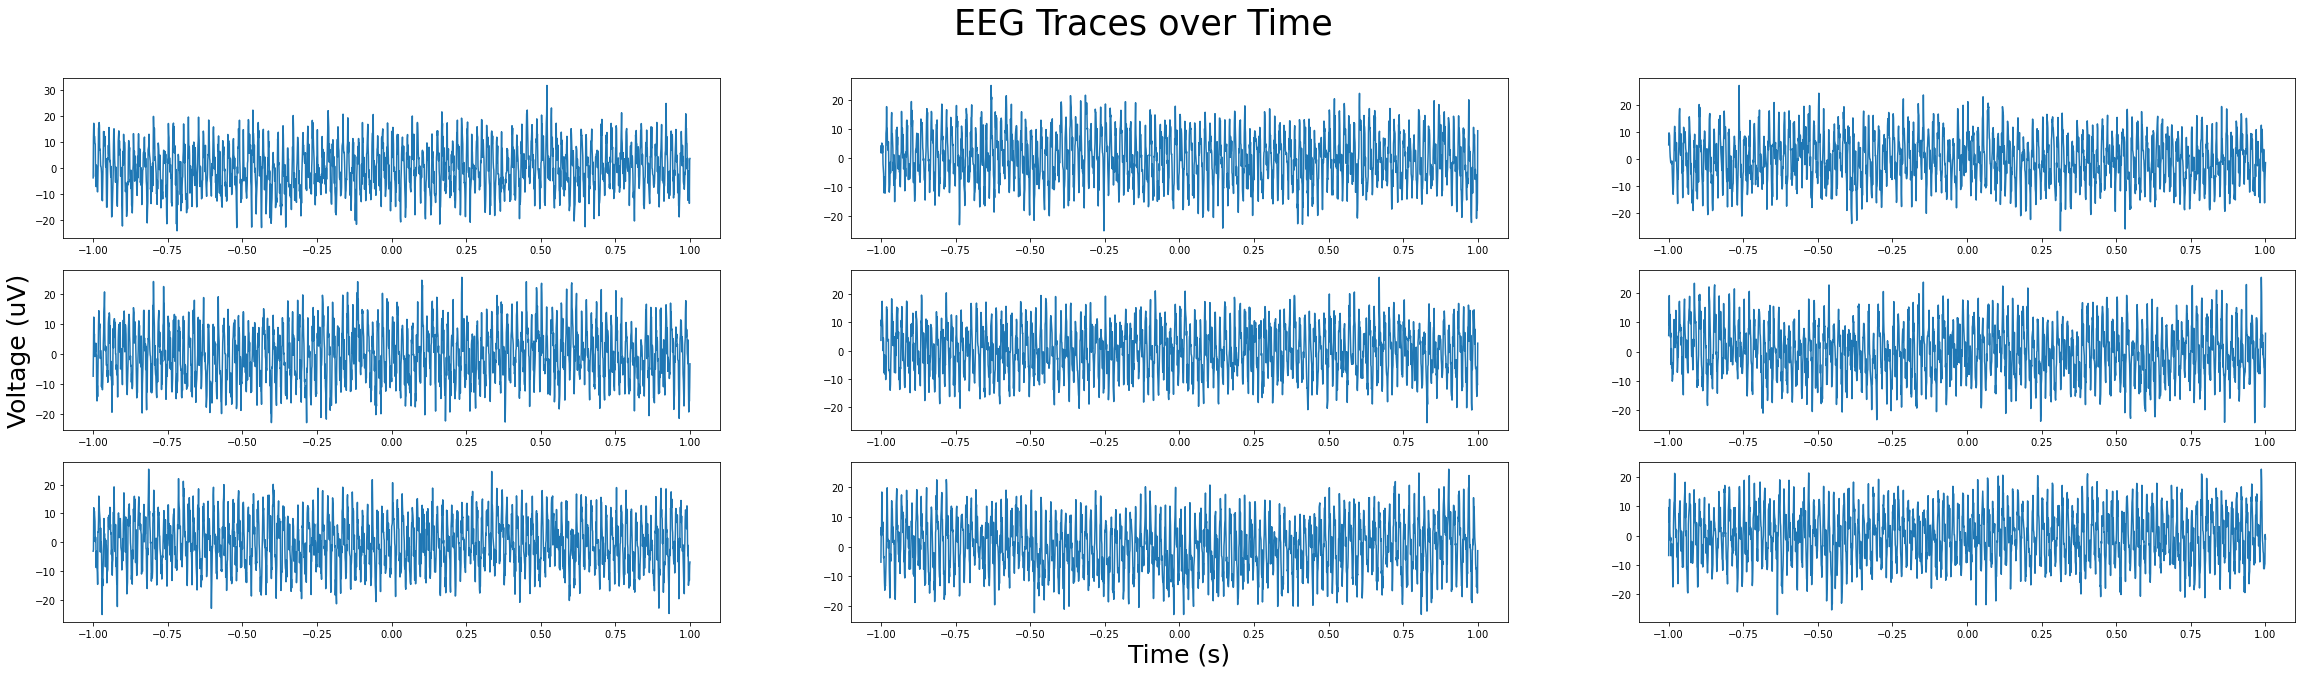

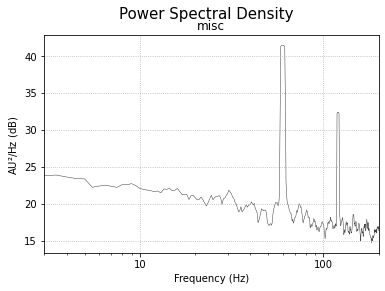

In [194]:
# pink noise spectra with heavy line noise

gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

duration = 2  # seconds

# line noise components
osc_freq = 60  # Hz
osc_amplitude_scale = 1.0
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

osc_freq = 120  # Hz
osc_amplitude_scale = 0.35
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

plot_eeg_signal(gen, duration=duration)

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/3079950.1.jupyter.q/ipykernel_69998/1277584110.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  xscale='log', ax=[ax])


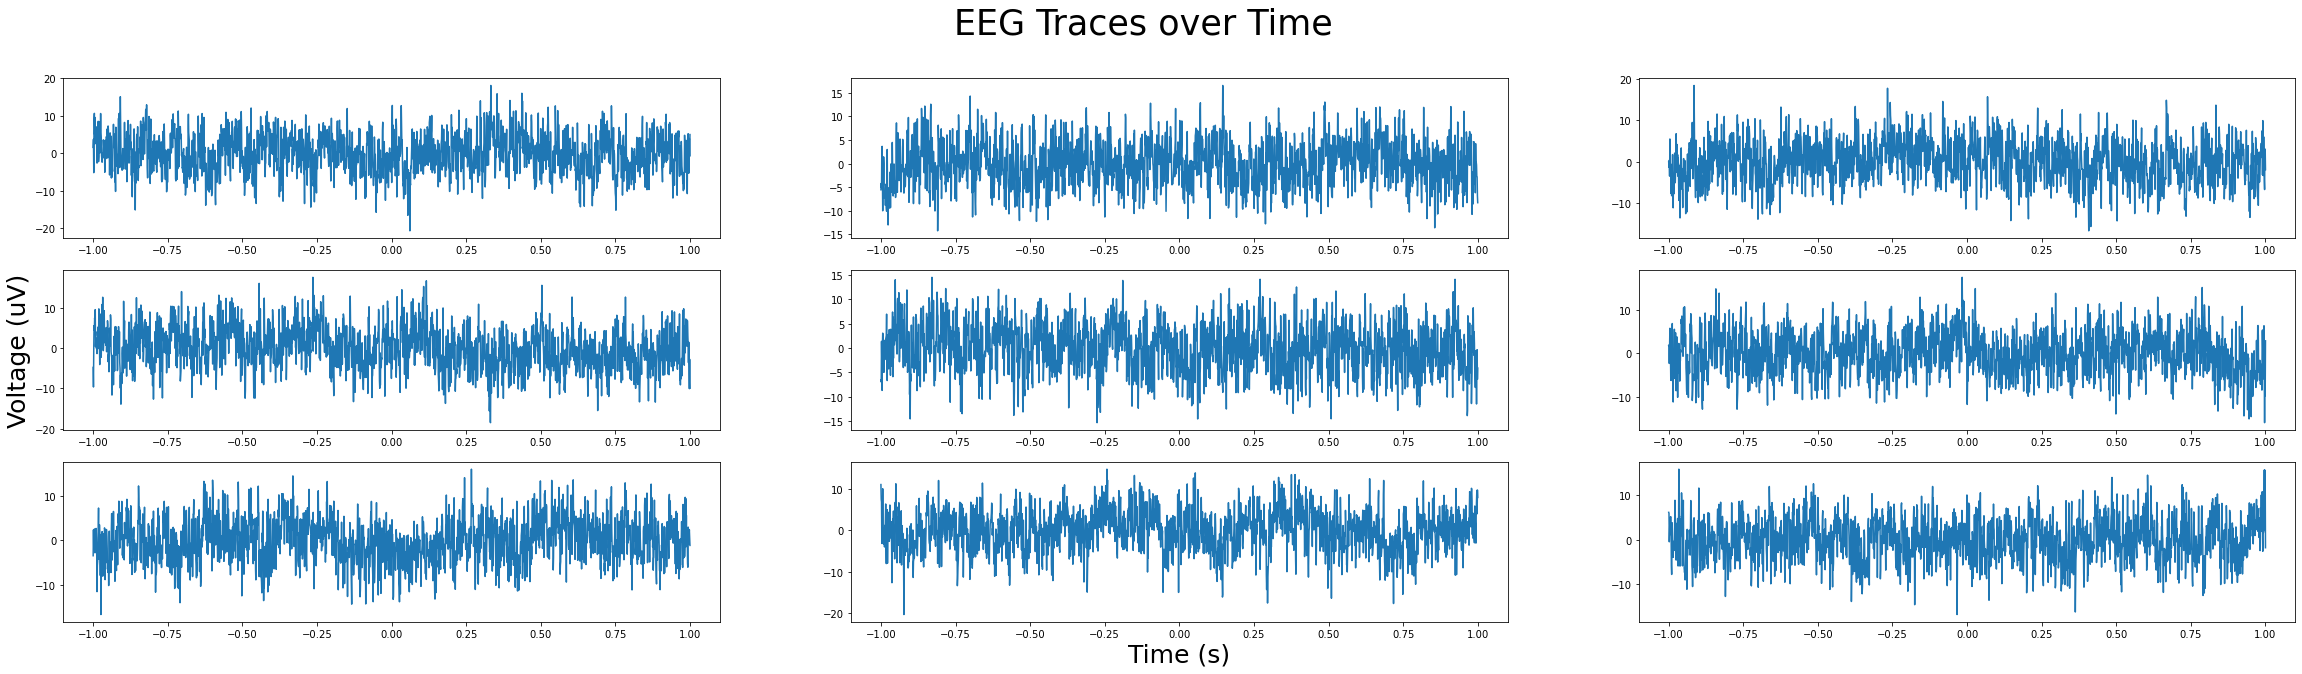

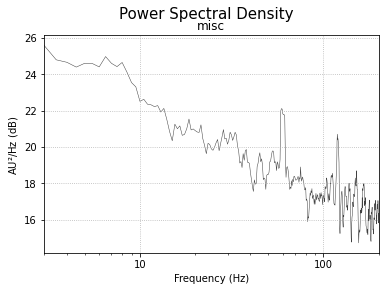

In [207]:
# pink noise spectra with acceptable line noise

gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

duration = 2  # seconds

# line noise components
osc_freq = 60  # Hz
osc_amplitude_scale = 0.07
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

osc_freq = 120  # Hz
osc_amplitude_scale = 0.05
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

plot_eeg_signal(gen, duration=duration)

Additional things to keep an eye on:
* Physiological (i.e. clean) EEG is weakly correlated across channels. If a non-pink-noise signal clearly appears on multiple channels simultaneously, it's suspicious and likely indicates artifacts.